In [1]:
include("Mondrian_Tree.jl")

predict! (generic function with 2 methods)

In [2]:
using MLBase
function Fakedata(n,dim) 
    x = randn(n,dim)
    y = (sum(exp.(x)/(1+exp.(x)),2)).>0.5
    return 1.0*x,1*y[:,1]
end

d=5
X, Y = Fakedata(1000,d);
D = (X,Y.+1)

x,y = Fakedata(100,d)
D_test = (x,y.+1)

# t = y.==1;

# using Plots
# scatter(x[t.==1,1],x[t.==1,2])
# scatter!(x[t.==0,1],x[t.==0,2])

In [83]:
type Mondrian_Tree_Classifier
    Tree::Mondrian_Tree
    λ::Float64
    γ::Float64
    X::Array{Float64,2}
    Y::Array{Int}
end

function Mondrian_Tree_Classifier(Tree::Mondrian_Tree)
    return Mondrian_Tree_Classifier(Tree,1e9,0,[],[])
end

function Mondrian_Tree_Classifier(Tree::Mondrian_Tree,λ::Float64)
    return Mondrian_Tree_Classifier(Tree,λ,0,[],[])
end

function Mondrian_Tree_Classifier(Tree::Mondrian_Tree,λ::Float64, Data)
    return Mondrian_Tree_Classifier(Tree,λ,0,[],[])
end

type Mondrian_Forest_Classifier
    n_trees::Int64
    Trees::Array{Mondrian_Tree}
    X::Array{Float64,2}
    Y::Array{Int}
end

function Mondrian_Forest_Classifier(n_trees::Int64)
    return Mondrian_Forest_Classifier(n_trees,
                                    Array{Mondrian_Tree,1}(),
                                    Array{Float64,2}(0,0),
                                    Array{Int}(0))
end

function train!(MT::Mondrian_Tree,X,Y,λ=1e9)
    Sample_Mondrian_Tree!(MT,λ,(X,Y))
    initialize_posterior_counts!(MT,(X,Y))
    compute_predictive_posterior_distribution!(MT,10*size(X,2))
end
function predict!(MT::Mondrian_Tree,X)
    pred = []
    for i in 1:size(X,1) 
        p = predict!(MT,X[i,:],10*size(X,2))
        if p[1] > p[2]
            push!(pred,1)
        else
            push!(pred,2)
        end
    end
    return pred
end

function train!(MF::Mondrian_Forest_Classifier, X, Y, λ)
    for i in 1:MF.n_trees
        T = Mondrian_Tree()
        train!(T, X, Y, λ)
        push!(MF.Trees,T)
    end
end

function predict!(MF::Mondrian_Forest_Classifier, X)
    pred = zeros(MF.n_trees,size(X,1))
    for i in 1:length(MF.Trees)
        pred[i,:] = predict!(MF.Trees[i], X)
    end
    p = Array{Int,1}(size(X,1))
    for i in 1:size(X,1)
        p[i] = mode(pred[:,i])
    end
    return p
end

predict! (generic function with 4 methods)

In [90]:
MF = Mondrian_Forest_Classifier(100)
train!(MF, D[1], D[2], 0.7)
pred=predict!(MF, D[1]);
println("Train Accuracy")
println(correctrate(D[2],convert(Array{Int,1},pred)))
pred=predict!(MF, D_test[1])
println("Accuracy") 
println(correctrate(D_test[2],convert(Array{Int,1},pred)))

(100, 1000)
Train Accuracy
0.989
(100, 100)
Accuracy
0.87


In [30]:
MT = Mondrian_Tree()
train!(MT,D[1],D[2],0.7)
pred=predict!(MT, D[1])
println("Train Accuracy")
println(correctrate(D[2],convert(Array{Int,1},pred)))
pred=predict!(MT, D_test[1])
println("Accuracy") 
println(correctrate(D_test[2],convert(Array{Int,1},pred)))

Train Accuracy
0.814
Accuracy
0.75


In [20]:
function Mondrian_Forest_predict!(D_train,D_pred,λ,nₜ=100)
    trees = Array{Mondrian_Tree}(nₜ)
    pred = Array{Int, 2}(nₜ,size(D_pred,1))
    for i in 1:nₜ
        trees[i] = Mondrian_Tree()
        train!(trees[i],D_train[1],D_train[2],λ)
        for j in 1:size(D_pred,1) 
            p = predict!(trees[i],D_pred[j,:],10*size(D_pred,2))
            if p[1] > p[2]
                pred[i,j] = 1
            else
                pred[i,j] = 2
            end
        end
    end
    p = Array{Int,1}(size(D_pred,1))
    for i in 1:size(D_pred,1)
        p[i] = mode(pred[:,i])
    end
    return p, trees
end
n=100
println("Train accuracy")
p ,T = Mondrian_Forest_predict!(D,D[1],1,n)
println(correctrate(p,convert(Array{Int,1},D[2])))
@time p,T = Mondrian_Forest_predict!(D,D_test[1],1,n)
println("Test accuracy")
println(correctrate(p,convert(Array{Int,1},D_test[2])))

Train accuracy


LoadError: [91mInterruptException:[39m

In [29]:
function get_data_indices!(Θ::Axis_Aligned_Box, D::Array{Float64,2})
    indices = []
    include = false
    for i in 1:size(D,1)
        for j in 1:size(Θ.Intervals,1)
            if (D[i,j] < Θ.Intervals[j,1] || D[i,j] > Θ.Intervals[j,2])
                include=false
                break
            end
        end
        
        if (include)    
            push!(indices, i)
        end
    end
    return indices
end

get_data_indices! (generic function with 1 method)

In [31]:
get_data_indices!(get(MT.leaves[1].Θ),D[1])

0-element Array{Any,1}

In [14]:
D[1][1,:]

5-element Array{Float64,1}:
  1.61289 
 -0.976647
 -1.21993 
 -1.57826 
 -0.620059

In [15]:
get(MT.leaves[2].Θ).Intervals

5×2 Array{Float64,2}:
  0.824519   0.824519
 -0.978809  -0.978809
 -2.29695   -2.29695 
 -1.56105   -1.56105 
 -1.12594   -1.12594 

In [395]:
@time function in_interval(vec, x)
    i = searchsortedlast(vec, x)
    i == length(vec) && (i = 0)
    return(i)
 end

find_interval(int,6)

  0.000074 seconds (13 allocations: 1.062 KiB)


0

  0.000561 seconds (4.93 k allocations: 108.484 KiB)


0-element Array{Any,1}

In [352]:
function cart(x,y)
    [repeat(x, inner=[size(y,1)]) repeat(y, outer=[size(x,1)])]
end

cart (generic function with 1 method)

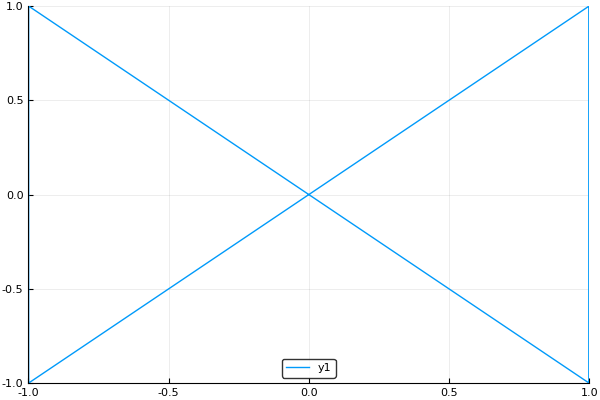

In [286]:
a = [1,-1]
b = [1,-1]
x
x=vcat(cart(a,b),cart(reverse(a),b))
plot(x[:,1],x[:,2])

In [284]:
x[:,1]

8-element Array{Int64,1}:
  1
  1
 -1
 -1
 -1
 -1
  1
  1

In [20]:
function Mondrian_Forest_predict!(D_train,D_pred,λ,nₜ=200)
    trees = Array{Mondrian_Tree}(nₜ)
    pred = Array{Int, 2}(nₜ,size(D_pred,1))
    for i in 1:nₜ
        trees[i] = Sample_Mondrian_Tree(λ,D_train)
        initialize_posterior_counts!(trees[i],D_train);
        compute_predictive_posterior_distribution!(trees[i],10*size(D_train[1],2));
        for j in 1:size(D_pred,1) 
            p = predict!(trees[i],D_pred[j,:],10*size(D_pred,2))
            if p[1] > p[2]
                pred[i,j] = 1
            else
                pred[i,j] = 2
            end
        end
    end
    p = Array{Int,1}(size(D_pred,1))
    for i in 1:size(D_pred,1)
        p[i] = mode(pred[:,i])
    end
    return p, trees
end
# println("Train accuracy")
# p = Mondrian_Forest_predict!(D,D[1],0.3)
# println(correctrate(p,convert(Array{Int,1},D[2])))
@time p,T = Mondrian_Forest_predict!(D,D_test[1],1e9,100)
println("Test accuracy")
println(correctrate(p,convert(Array{Int,1},D_test[2])))

LoadError: [91mUndefVarError: Sample_Mondrian_Tree not defined[39m

In [20]:
t_test = p.==2;

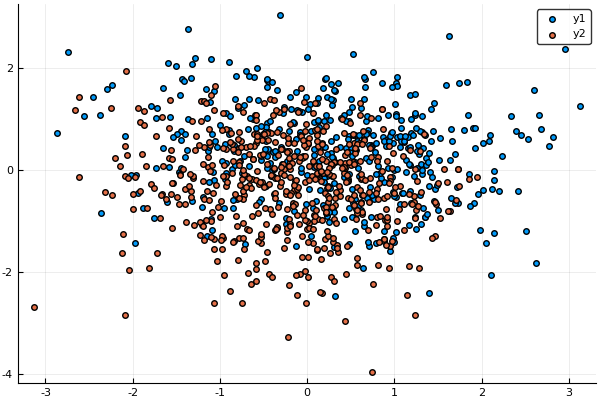

In [21]:
scatter(x[t_test.==1,1],x[t_test.==1,2])
scatter!(x[t_test.==0,1],x[t_test.==0,2])

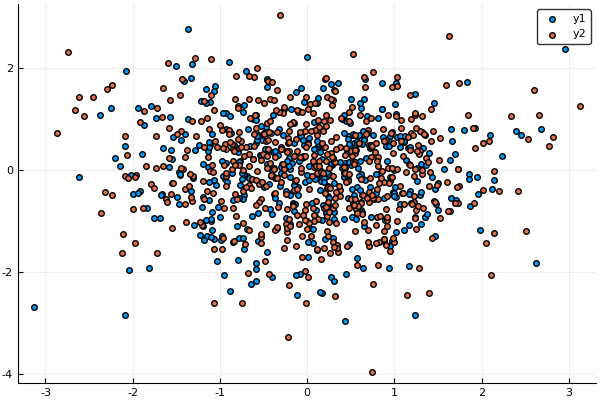

In [22]:
scatter(x[t.==1,1],x[t.==1,2])
scatter!(x[t.==0,1],x[t.==0,2])

In [39]:
x = [1,10,25,50,100]
t = zeros(length(x))
for i in 1:length(x)
    t[i] = (@allocated Mondrian_Forest_predict!(D,D_test[1],0.15,x[i]))
end

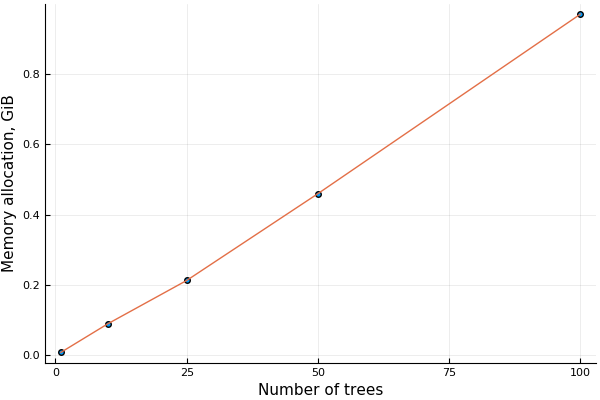

In [40]:
using Plots
scatter(x,t./1e9, label="")
plot!(x,t./1e9, label="")
xlabel!("Number of trees")
ylabel!("Memory allocation, GiB")

In [29]:
using DecisionTree
@time forest = build_forest(Y, X, d, 1)

pred = 1*apply_forest(forest,x)
println("Correct: ", correctrate(y, pred))
println("Error: ", errorrate(y,pred))

  0.119819 seconds (51.36 k allocations: 4.472 MiB)
Correct: 0.76
Error: 0.24


In [104]:
for leaf in MT.leaves
    println(leaf.c)
end

[0, 0]
[0, 0]
[0, 1]
[0, 0]
[38, 0]
[2, 3]
[0, 0]
[6, 5]
[35, 2]
[30, 19]
[0, 0]
[0, 0]
[7, 3]
[394, 182]
[0, 0]
[0, 1]
[0, 1]
[21, 26]
[0, 38]
[1, 45]
[0, 2]
[0, 20]
[0, 25]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 1]
[0, 10]
[0, 0]
[0, 1]
[0, 32]
[0, 0]
[0, 0]
[0, 24]
[0, 3]
[0, 21]
[0, 1]


In [24]:
include("load_titanic.jl")
x_train, y_train, x_test, y_test = load();
D = (x_train, y_train.+1)
D_test = (x_test,y_test.+1)
@time MT = Sample_Mondrian_Tree(1e9,D);
initialize_posterior_counts!(MT,D);
compute_predictive_posterior_distribution!(MT,10*size(D[1],2));

  0.157480 seconds (594.31 k allocations: 15.268 MiB)


In [27]:
using MLBase
pred = []
for i in 1:size(D_test[1],1) 
    p = predict!(MT,D_test[1][i,:],10*size(D_test[1],2))
    if p[1] > p[2]
        push!(pred,1)
    else
        push!(pred,2)
    end
end
println(correctrate(D_test[2],convert(Array{Int,1},pred)))
println(unique(pred))

0.625
[1, 2]


In [32]:
@time p,T = Mondrian_Forest_predict!(D,D_test[1],1e16,100)
println("Test accuracy")
println(correctrate(p,convert(Array{Int,1},D_test[2])))

  4.685938 seconds (88.55 M allocations: 1.902 GiB, 15.52% gc time)
Test accuracy
0.7


In [43]:
D[1][1,2] < a.Intervals[2,1] || D[1][1,2] > a.Intervals[2,2]

false

In [40]:
D[1,2]

LoadError: [91mMethodError: no method matching getindex(::Tuple{Array{Float64,2},Array{Int64,1}}, ::Int64, ::Int64)[39m

In [22]:
Y = [1,2,2,2,1]

5-element Array{Int64,1}:
 1
 2
 2
 2
 1

In [24]:
size(Y[Y.==1],1)

2

In [16]:
ones(2)

2-element Array{Float64,1}:
 1.0
 1.0

In [17]:
exp(2)

7.38905609893065

In [19]:
sum([1,2,3])

6